# How likely is it that a drunk can find the bathroom?

An examination of using Monte Carlo methods to extract statistically significant results from difficult problems.

Z. W. Miller - 1/19/18

## Let's start by importing the stuff we'll need and then checking some version numbers. Note that we're in Python 3 here.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


## Start by setting up a random walk method

So we know we're going to be setting up a random walker, and we want to set it up such that the rules of the game follow along with the post here: http://zwmiller.com/projects/monte_carlo_part1.html

The 4 main rules are:

1. Every time we take a step, we roll a dice to see what direction we go in.
2. If the step places our intoxicated bro inside a table or through a wall, we stop the simulation and call it a "failure to make it to the bathroom."
3. If the step places our blitzed comrade through the bathroom door, we stop the simulation and call it a success.
4. If this is his 50th step since leaving the bar, we'll stop there because we don't believe he could realistically take that many steps in a row. This will constitute a failure.

So we need a few things:

1. The ability to track the position of our drunk.
2. We need to be able to roll a dice to get an angle of where we will step. We can draw a random integer between 0 and 359 degrees for this (we'll need to convert it to radians so that we can use sine and cosine, though: https://www.youtube.com/watch?v=r0fv9V9GHdo).
3. Some function that actually takes a step based on the conversion of the angle to x and y coordinates.
4. Some method to check if we've run into a wall or not (we'll skip tables for this case).
5. Some method to check if we've hit our goal of making it to the bathroom

These next functions will help take care of all of that.

In [99]:
def convert_to_rads(degrees):
    """
    Helper Function to convert degrees to radians
    
    Input: degrees (0-360) int
    Output: float, angle in radians
    """
    return float(((2*np.pi)/360)*degrees)

def take_step(position, step_size):
    """
    Takes a step for our walker.
    Input: (x, y) position in a list
    Output: (x, y) updated, in a list
    """
    angle_degrees = np.random.randint(0,360)
    angle_radians = convert_to_rads(angle_degrees)
    new_x = position[0] + step_size*np.cos(angle_radians)
    new_y = position[1] + step_size*np.sin(angle_radians)
    return [new_x, new_y]

def check_the_rules(position, x_range, y_range, goal_range):
    """
    Helper function to decide if our walker dies, lives,
    or has succeeded
    Input: Position (x, y), x_range (low, high), y_range (low, high)
           goal_range (low_x, low_y, high_x, high_y)
    Output: Int (0-dead, 1-live, 2-succeeded)
    """
    x = position[0]
    y = position[1]
    
    if x < x_range[0] or x > x_range[1]:
        return 0
    if y < y_range[0] or y > y_range[1]:
        return 0
    
    if x > goal_range[0] and y > goal_range[1] and x < goal_range[2] and y < goal_range[3]:
        return 2
    
    return 1


def walker_episode(position=None, x_range=(0,10), y_range=(0,10), number_of_steps=50, step_size=1, 
                   goal_range=(9,9,10,10)):
    """
    Sets the walker in motion and then plays by the rules we've decided.
    First we put the walker into the room (with a starting position)
    then we let him walk for however many steps we think is possible,
    taking each step by rolling the dice and then moving in that direction.
    We'll also track the path of the walker so we can visualize it later.
    """
    if not position or len(position) != 2:
        position = [np.random.uniform(x_range[0], x_range[1]), np.random.uniform(y_range[0], y_range[1])]
    
    position_tracker = [position]
    
    for step in range(number_of_steps):
        position = take_step(position, step_size)
        position_tracker.append(position)
        survives = check_the_rules(position, x_range, y_range, goal_range)
        if survives == 0 or survives == 2:
            break
    
    return position_tracker, survives

Awesome, we're all ready to go. Let's set our walker loose and let it run until we make our goal (that way we can make sure it's stopping when we hit the goal). Note that up above we defined a "0" output as a crash, a "1" output as "he's still walking and hasn't bumped into anything when the number of steps ran out" and a "2" as a successfully making it to the bathroom. We've also said that by default the "goal" will be to step in the square between that touches the walls in the upper right corner (9 < x < 10, 9 < y < 10). We'll draw that here in a bit.

In [62]:
result = 0
while result == 0:
    walk_path, result = walker_episode(position=(4,4), number_of_steps=100)
    print(result)

0
0
0
0
0
2


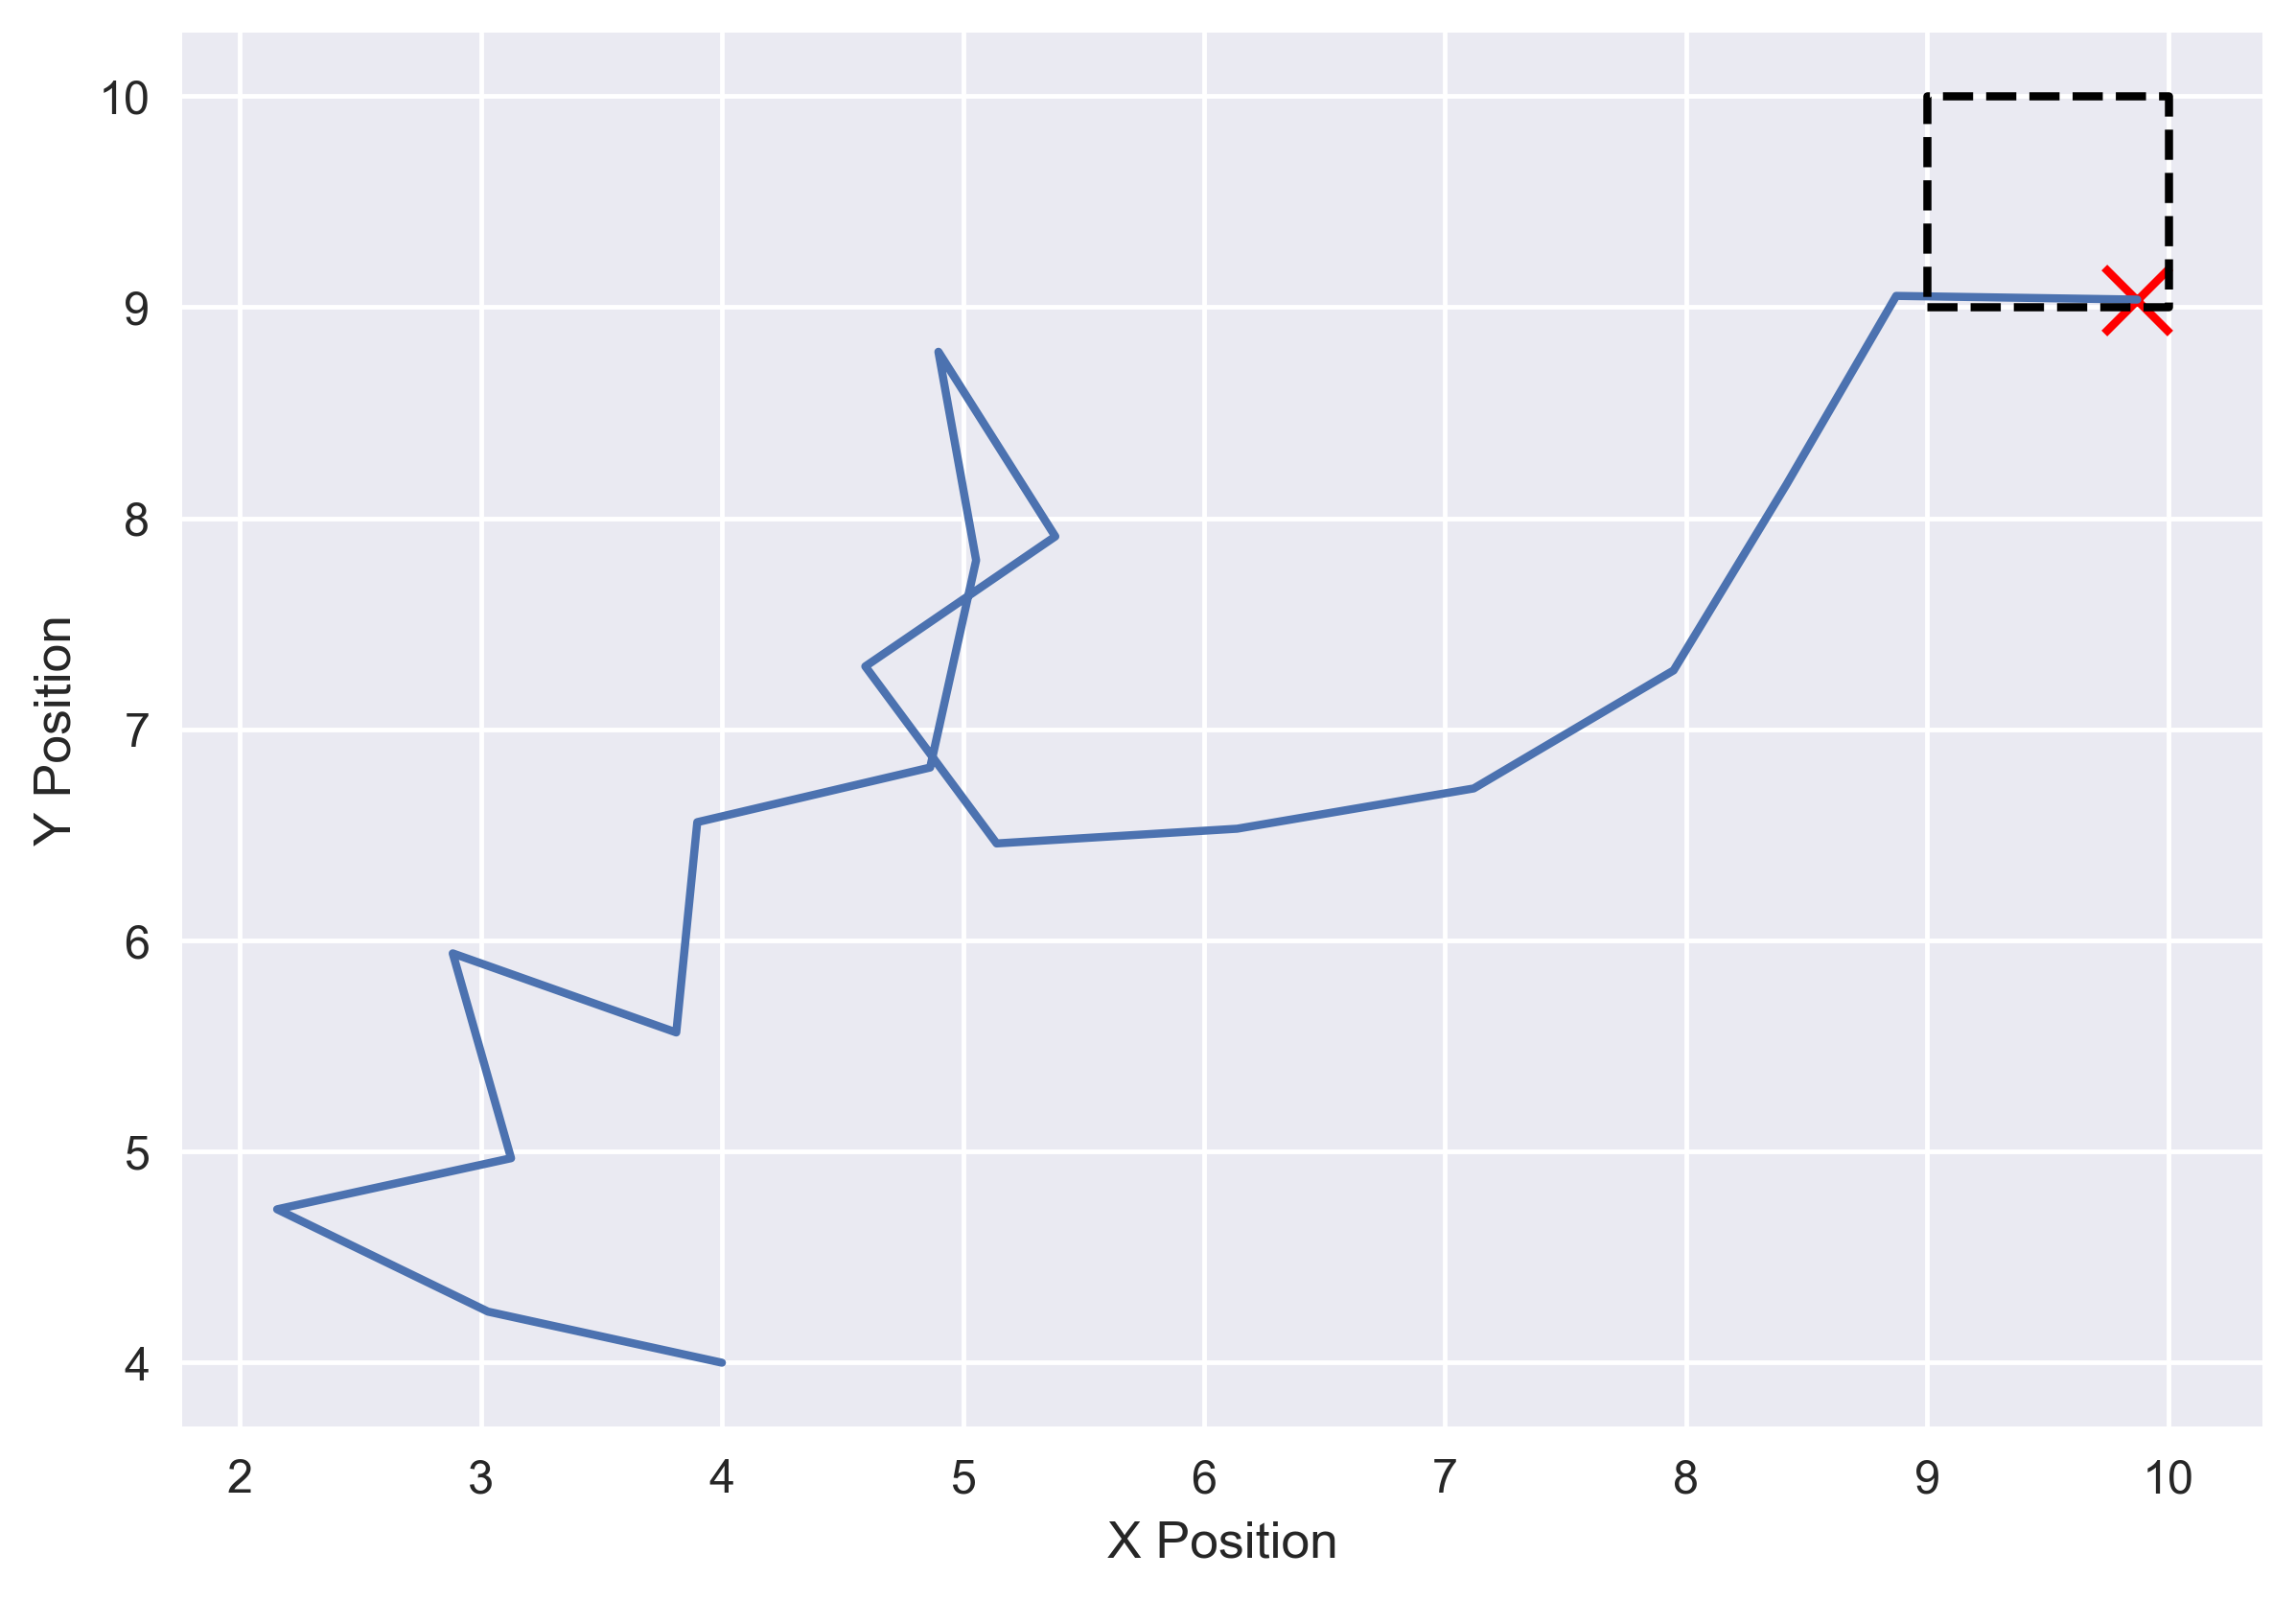

In [64]:
def draw_path(walk_path):
    x, y = zip(*walk_path)
    plt.figure(dpi=350)
    plt.plot(x, y)
    plt.scatter(x[-1], y[-1],marker='x',c='r', s=200);
    plt.plot([9,10,10,9,9],[9,9,10,10,9],'k--')
    plt.xlabel("X Position")
    plt.ylabel("Y Position");
    
draw_path(walk_path)

Alright! We made it. You can see that the walker started at (4,4) where we wanted him to, then for the first 5 tries he bounced off a wall (hence the 0's when we printed out the results above). However, he finally survived a walk and ended up in the square of bathroomness. 

So if we want to estimate a "percentage chance that he makes it," we just need to run this many, many times and then see how often her does. Let's do that and use the same "dictionary counting" trick we did with our previous examples to track the succes rate.

In [67]:
results = {0:0, 1:0, 2:0}
number_of_walkers = 10000
for walker in range(number_of_walkers):
    walk_path, result = walker_episode(position=(5,5), number_of_steps=100)
    results[result] += 1
    
print("Goal Percentage: ", results[2]/number_of_walkers*100)
print("Still Alive, but no goal: ", results[1]/number_of_walkers*100)
print("Crashed into wall: ", results[0]/number_of_walkers*100)

Goal Percentage:  2.23
Still Alive, but no goal:  1.92
Crashed into wall:  95.85000000000001


So it looks like our drunk, if he starts in the exact middle of the room and has up to 100 steps worth of walking power, has a 2.23% chance of urinating in a place where we expect him to. That's both neat and disgusting. How sure are we that our method has converged to that 2%-ish number? We should make sure we aren't still in a zone of high fluctuation. 

## Now let's see how our confidence is tied to the number of episodes

To check that out, we'll re-run the simulation many times - sometimes we'll only do a few episodes, others we'll do thousands. Then we'll plot our estimate of his success rate vs how many episodes we ran.

In [71]:
survival_esimations = []
for number_of_walkers in range(1,10000,10):
    results = {0:0, 1:0, 2:0}
    for walker in range(number_of_walkers):
        walk_path, result = walker_episode(position=(5,5), number_of_steps=100)
        results[result] += 1
    survival_esimations.append(results[2]/number_of_walkers)

In [72]:
len(survival_esimations)

1000

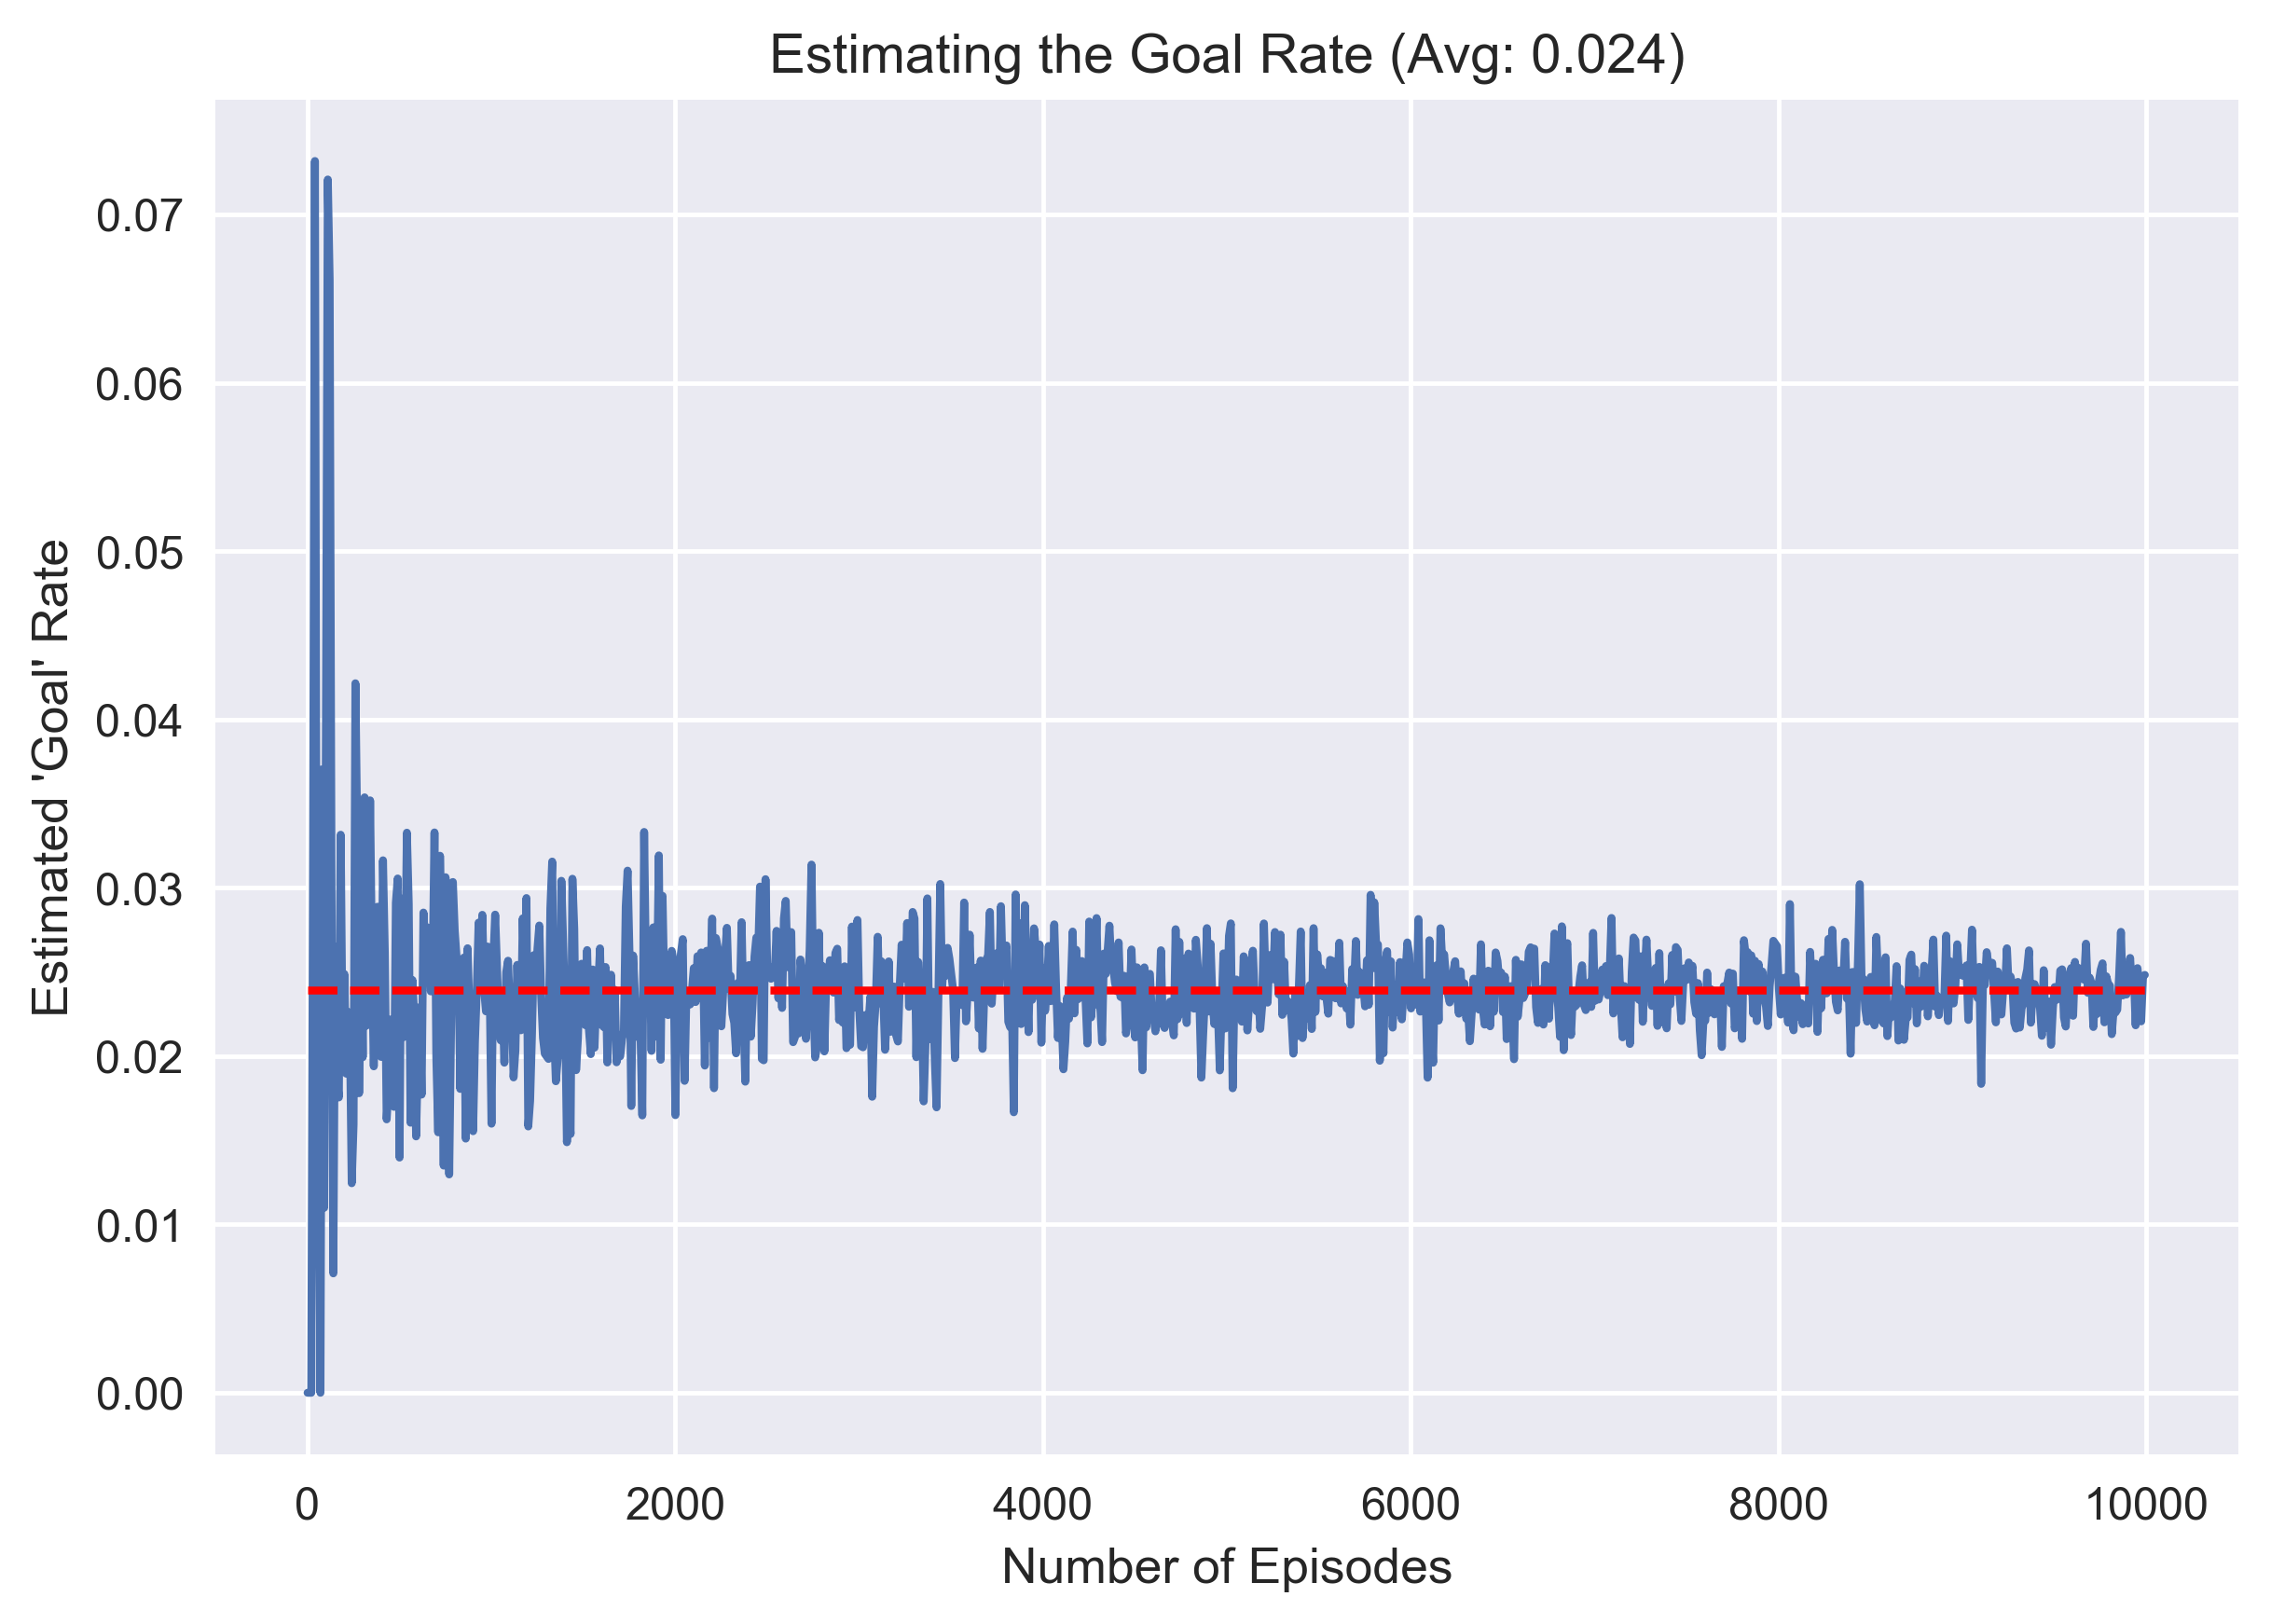

In [82]:
plt.figure(dpi=350)
plt.xlabel("Number of Episodes")
plt.ylabel("Estimated 'Goal' Rate")
plt.plot(range(1,10000,10), survival_esimations);
plt.plot([0,10000],[np.mean(survival_esimations), np.mean(survival_esimations)],'r--');
plt.title("Estimating the Goal Rate (Avg: %.3f)"%np.mean(survival_esimations));

Nice! It's still fairly noisy, but we can see that it's pretty well converged by the time we get to 10,000 episodes. So we can be fairly confident in that result. Now, let's make a pretty picture where we show a sampling of the different paths our drunk walks. Let's just run as many episodes as we need to get a success; so we should be able to see lots of failures (that will map along the edge of the room) and then one success. We'll also put a dot where he started so we can see his origination point.

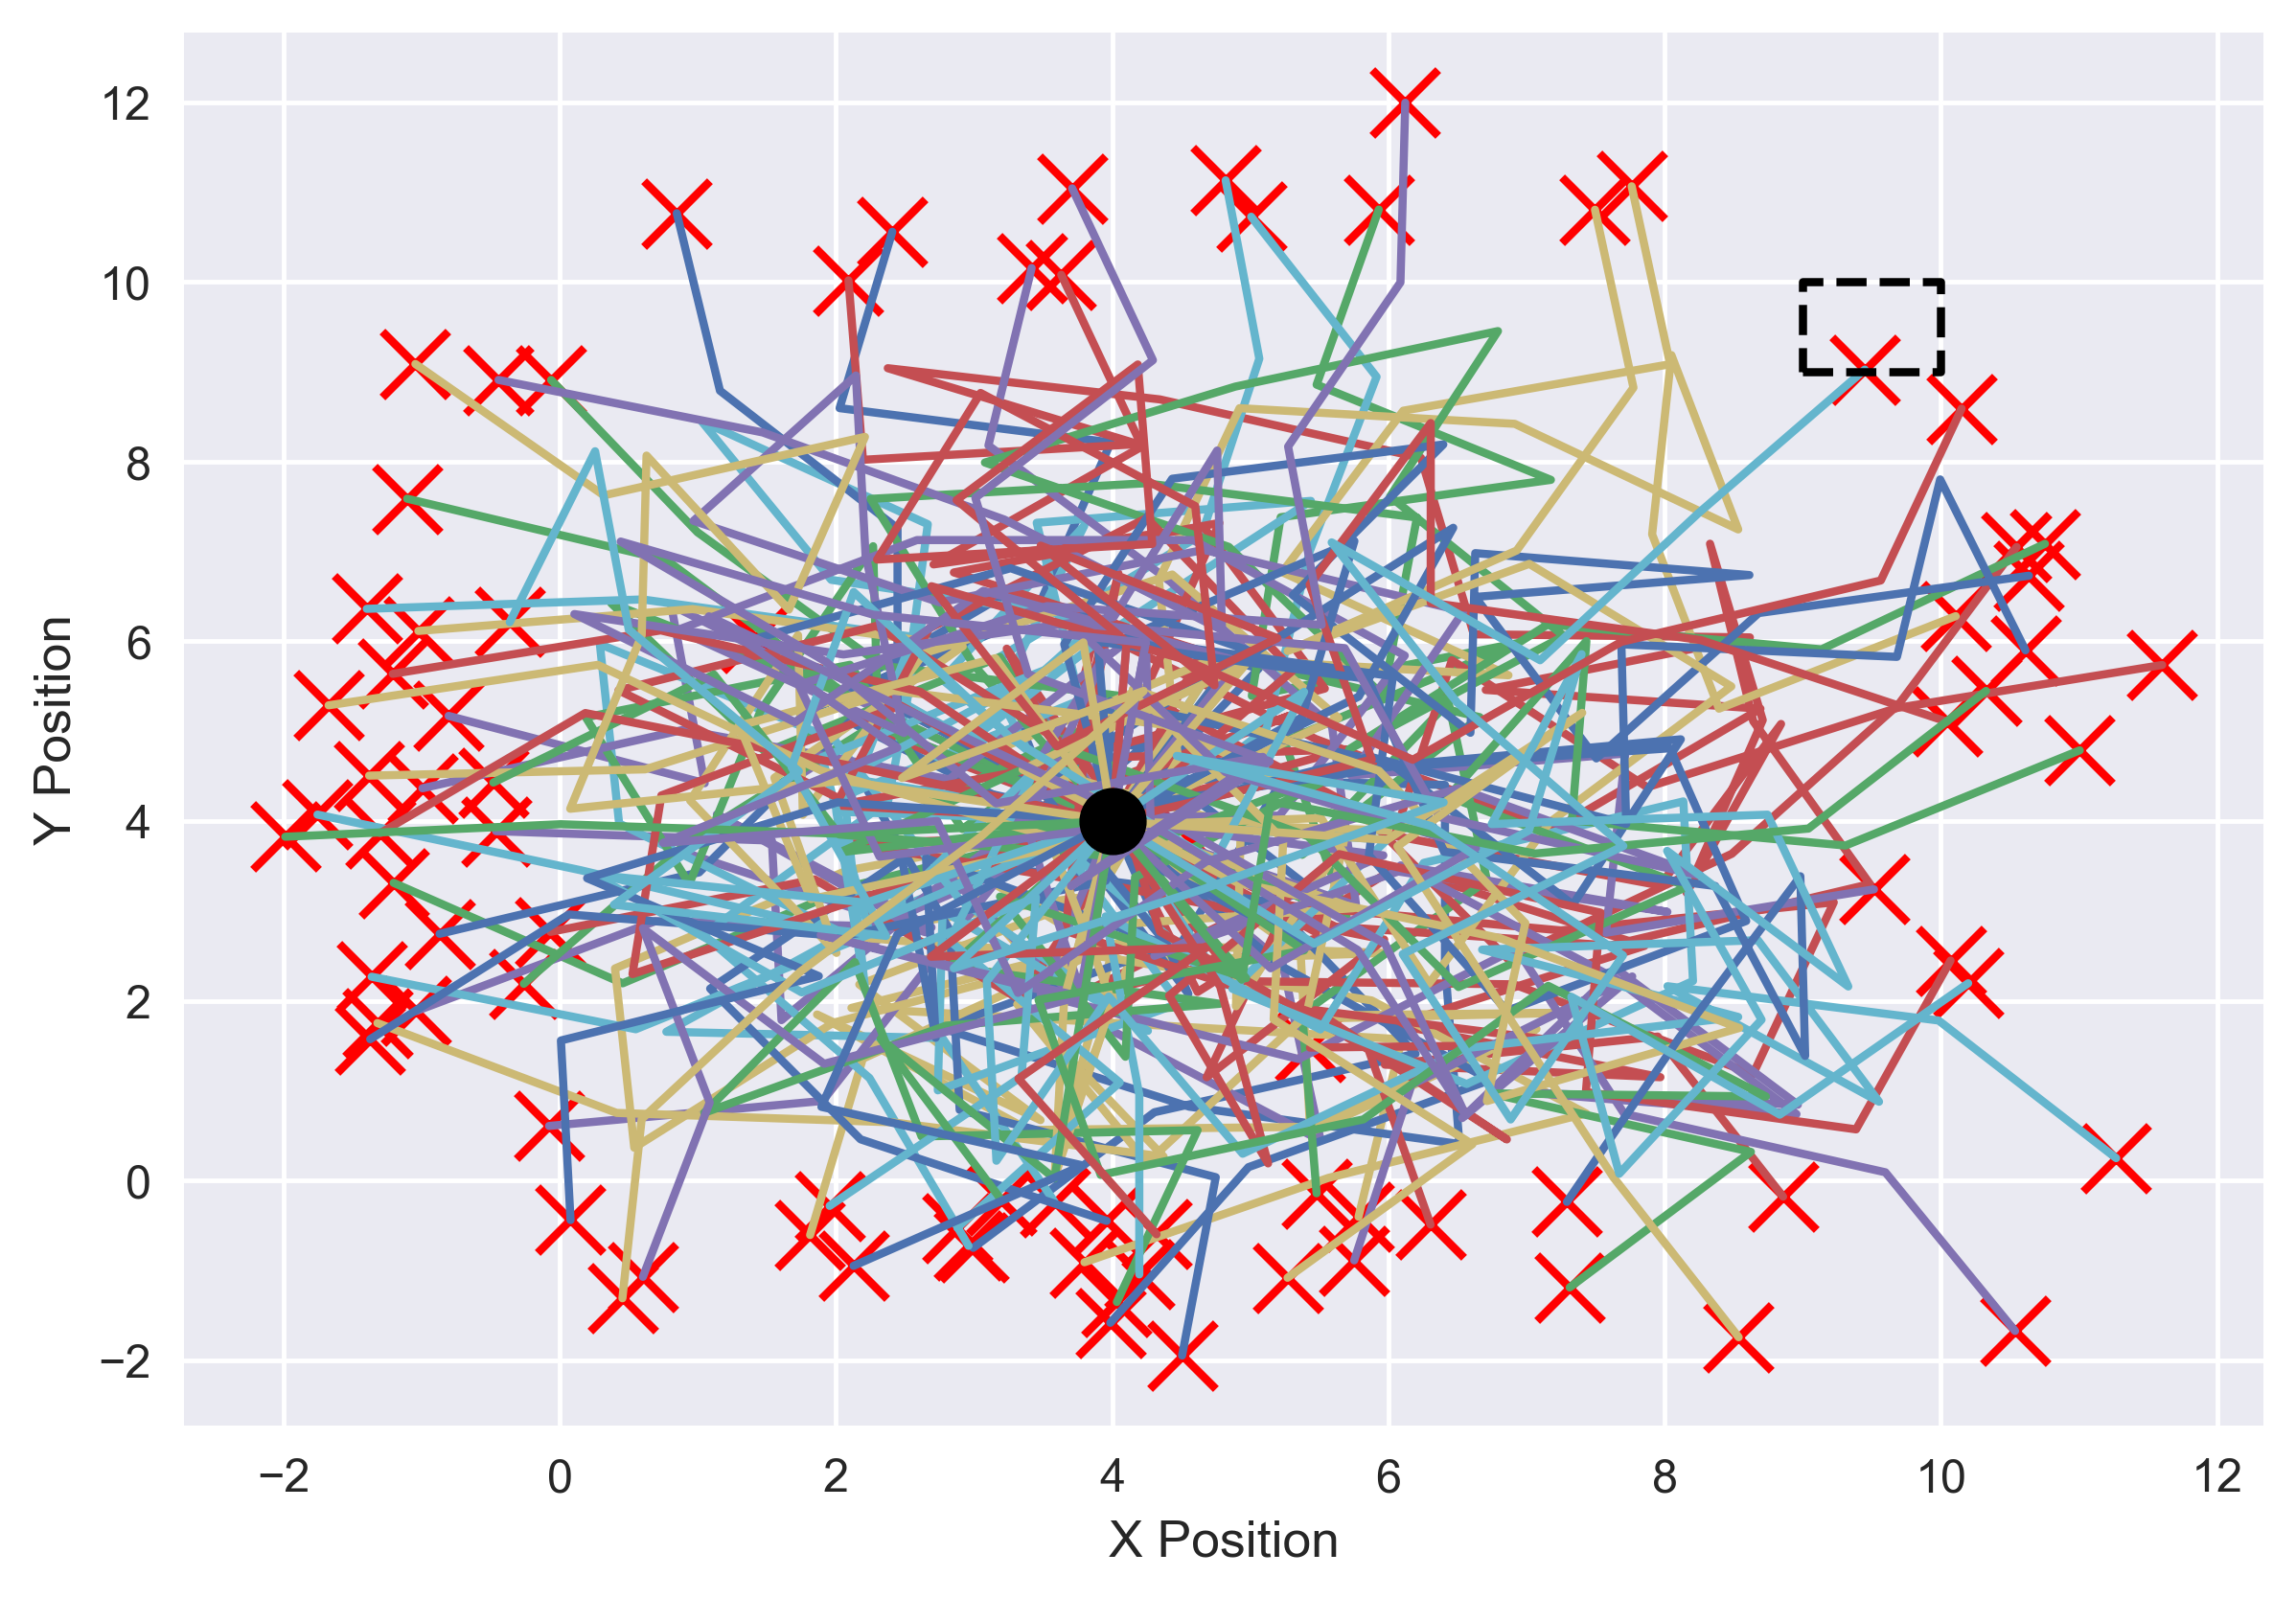

In [98]:
def draw_many_paths(walk_paths):
    plt.figure(dpi=350)
    for walk_path in walk_paths:
        x, y = zip(*walk_path)
        plt.plot(x, y)
        plt.scatter(x[-1], y[-1],marker='x',c='r', s=200);
    plt.scatter([4],[4],marker='o',c='k',s=200, zorder=10)
    plt.plot([9,10,10,9,9],[9,9,10,10,9],'k--')
    plt.xlabel("X Position")
    plt.ylabel("Y Position");

result = 0
walk_paths = []
while result!=2:
    walk_path, result = walker_episode(position=(4,4), number_of_steps=20, step_size=2)
    walk_paths.append(walk_path)
draw_many_paths(walk_paths)

NICE. That looks really cool and we can see very well just HOW MANY ways there are to fail and how small the window of success is comparitively. So our 2% number looks pretty good. 

# Back to http://zwmiller.com/projects/monte_carlo_part2.html